In [1]:
import vishack
import matplotlib.pyplot as plt
import numpy as np
import control
import kontrol

data1 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241101.xml")
data2 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241103.xml")
data3 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241115.xml")
data4 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241120.xml")
data5 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241203.xml")

In [2]:
data_list = [data1, data2, data3, data4, data5]
seis_list = []
res_list = []
log_seis_list = []
log_res_list = []

s = control.tf("s")
seis_cal = 1/s*1e-9

for data in data_list:
    f, seis = data.psd("L1:ISI-GND_STS_HAM8_Y_DQ")
    f, coh = data.coh("L1:ISI-GND_STS_HAM8_Y_DQ", "L1:ISI-HAM8_FF_Y_IN1_DQ")
    seis = seis[f>0]
    coh = coh[f>0]
    seis = seis * abs(seis_cal(1j*2*np.pi*f))
    res = (seis**2 * (1-coh**.5))**.5

    seis_list.append(seis)
    log_seis_list.append(np.log10(seis))
    res_list.append(res)
    log_res_list.append(np.log10(res))

seis_mean = 10**np.mean(log_seis_list, axis=0)
seis_std = np.std(log_seis_list, axis=0)
seis_sigma1 = 10**(np.log10(seis_mean) + seis_std)
seis_sigma2 = 10**(np.log10(seis_mean) + 2*seis_std)

res_mean = 10**np.mean(log_res_list, axis=0)
res_std = np.std(log_res_list, axis=0)
res_sigma1 = 10**(np.log10(res_mean) + res_std)
res_sigma2 = 10**(np.log10(res_mean) + 2*res_std)

f = f[f>0]

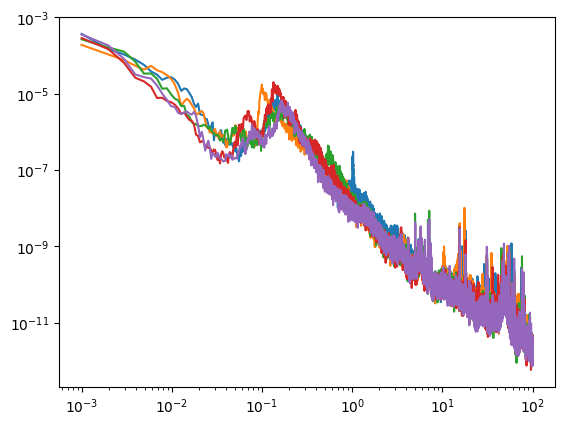

In [3]:
for seis in seis_list:
    plt.loglog(f, seis)
# plt.loglog(f, seis_mean)
# plt.loglog(f, seis_sigma1)
# plt.loglog(f, seis_sigma2)

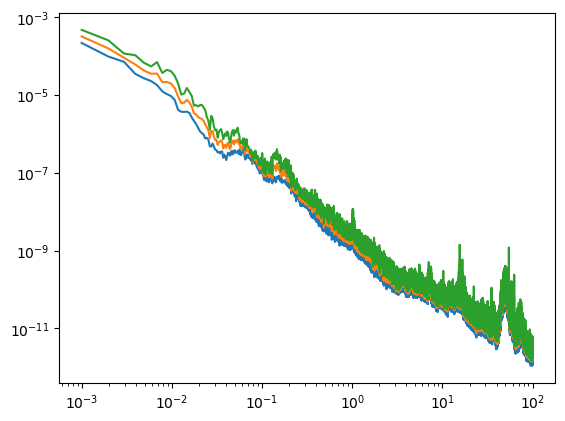

In [410]:
# for res in res_list:
    # plt.loglog(f, res)
plt.loglog(f, res_mean)
plt.loglog(f, res_sigma1)
plt.loglog(f, res_sigma2)

In [474]:
seis_mean[f<.041] = seis_mean[f>.041][0]
seis_mean_pad = seis_mean.copy()
seis_mean_pad[f>1] = seis_mean[f<1][-1]

seis_sigma1[f<.043] = seis_sigma1[f>.043][0]
seis_sigma1_pad = seis_sigma1.copy()
seis_sigma1_pad[f>1] = seis_sigma1[f<1][-1]

seis_sigma2[f<.043] = seis_sigma2[f>.043][0]
seis_sigma2_pad = seis_sigma2.copy()
seis_sigma2_pad[f>1] = seis_sigma2[f<1][-1]

res_mean_pad = res_mean.copy()
res_mean[f<.003] = res_mean[f>.003][0]
res_mean_pad[f>1] = res_mean[f<1][-1]

res_sigma1_pad = res_sigma1.copy()
res_sigma1_pad[f<.003] = res_sigma1[f>.003][0]
res_sigma1_pad[f>1] = res_mean[f<1][-1]

res_sigma2_pad = res_sigma2.copy()
res_sigma2_pad[f<.003] = res_sigma2[f>.003][0]
res_sigma2_pad[f>1] = res_mean[f<1][-1]

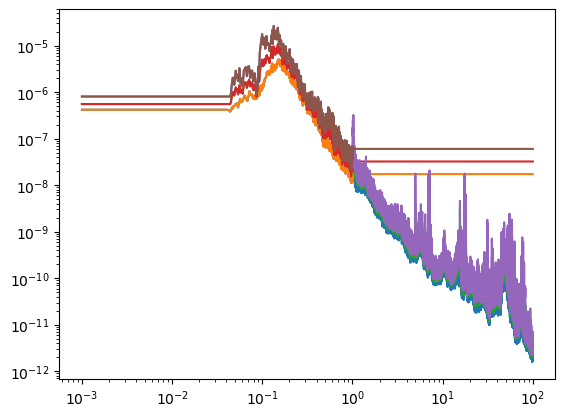

In [475]:
plt.loglog(f, seis_mean)
plt.loglog(f, seis_mean_pad)

plt.loglog(f, seis_sigma1)
plt.loglog(f, seis_sigma1_pad)

plt.loglog(f, seis_sigma2)
plt.loglog(f, seis_sigma2_pad)

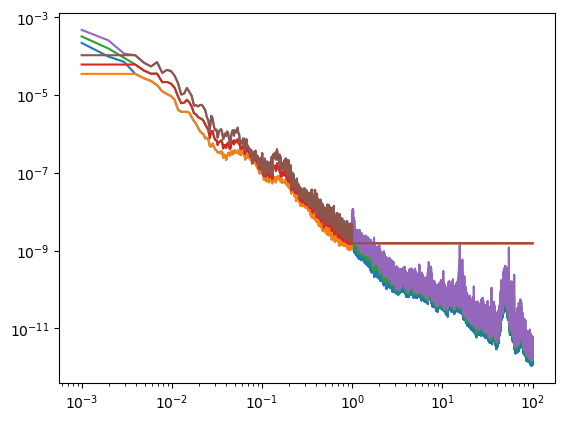

In [441]:
plt.loglog(f, res_mean)
plt.loglog(f, res_mean_pad)
plt.loglog(f, res_sigma1)
plt.loglog(f, res_sigma1_pad)
plt.loglog(f, res_sigma2)
plt.loglog(f, res_sigma2_pad)

In [415]:
seis_fit = kontrol.curvefit.spectrum_fit(f=f[f<10], spectrum=seis_mean_pad[f<10], nzero=5, npole=5)

In [417]:
res_fit = kontrol.curvefit.spectrum_fit(f=f[f<10], spectrum=res_mean_pad[f<10], nzero=5, npole=5)

In [442]:
res_sigma1_fit = kontrol.curvefit.spectrum_fit(f=f[f<10], spectrum=res_sigma1_pad[f<10], nzero=5, npole=5)

In [443]:
res_sigma2_fit = kontrol.curvefit.spectrum_fit(f=f[f<10], spectrum=res_sigma2_pad[f<10], nzero=5, npole=5)

In [287]:
f_ = np.logspace(-4, 2, 1024)

In [336]:
def noise_model(f, na, nb, a, b):
    noise = ((na/f**a)**2+(nb/f**b)**2)**.5
    return noise
n_ade1_params = [1*10**-10.0625, 2e-10, 0.75, 0]
n_cps = noise_model(f, *n_ade1_params)

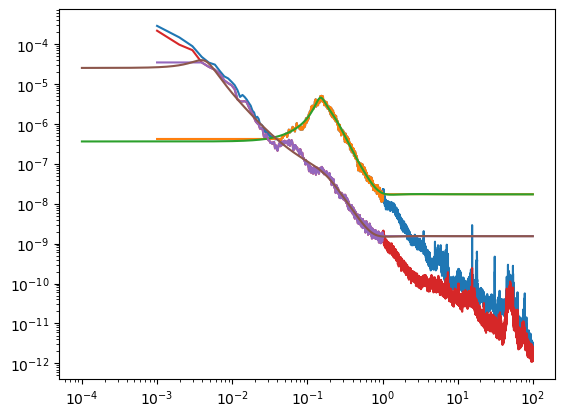

In [444]:
plt.loglog(f, seis_mean)
plt.loglog(f, seis_mean_pad)
plt.loglog(f_, abs(seis_fit(1j*2*np.pi*f_)))
plt.loglog(f, res_mean)
plt.loglog(f, res_mean_pad)
plt.loglog(f_, abs(res_fit(1j*2*np.pi*f_)))
# plt.loglog(f, n_cps)

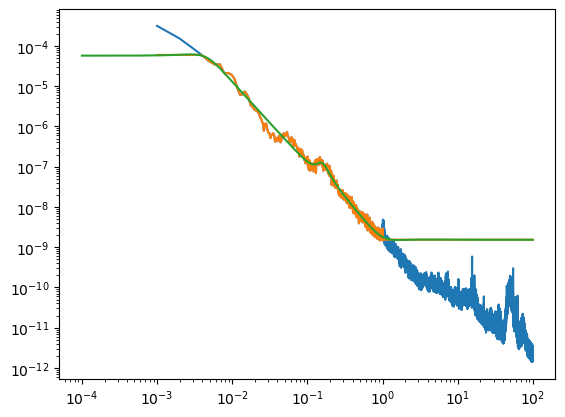

In [445]:
plt.loglog(f, res_sigma1)
plt.loglog(f, res_sigma1_pad)
plt.loglog(f_, abs(res_sigma1_fit(1j*2*np.pi*f_)))

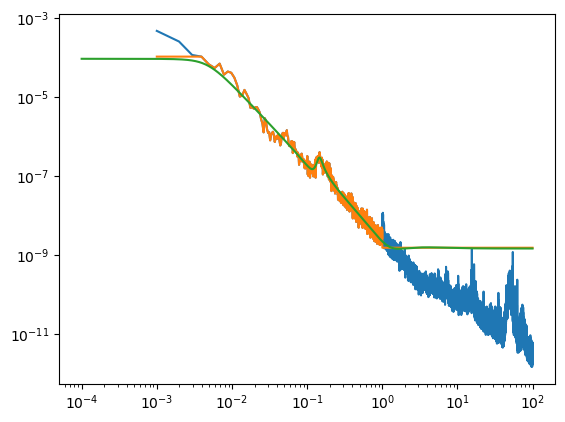

In [446]:
plt.loglog(f, res_sigma2)
plt.loglog(f, res_sigma2_pad)
plt.loglog(f_, abs(res_sigma2_fit(1j*2*np.pi*f_)))

In [482]:
comp = kontrol.ComplementaryFilter()
comp.noise1 = seis_fit
comp.noise2 = res_fit
comp.weight1 = 1/res_fit
comp.weight2 = 1/seis_fit
h1, h2 = comp.h2synthesis()
h1, h2 = comp.hinfsynthesis()

In [447]:
comp_sigma1 = kontrol.ComplementaryFilter()
comp_sigma1.noise1 = seis_fit
comp_sigma1.noise2 = res_sigma1_fit
comp_sigma1.weight1 = 1/res_sigma1_fit
comp_sigma1.weight2 = 1/seis_fit
h1_sigma1, h2_sigma1 = comp_sigma1.h2synthesis()
h1_sigma1, h2_sigma1 = comp_sigma1.hinfsynthesis()

In [448]:
comp_sigma2 = kontrol.ComplementaryFilter()
comp_sigma2.noise1 = seis_fit
comp_sigma2.noise2 = res_sigma2_fit
comp_sigma2.weight1 = 1/res_sigma2_fit
comp_sigma2.weight2 = 1/seis_fit
h1_sigma2, h2_sigma2 = comp_sigma2.h2synthesis()
h1_sigma2, h2_sigma2 = comp_sigma2.hinfsynthesis()

In [483]:
prefilt = (s/(s+2*np.pi*0.003))**3
h2p = h2*prefilt
h1p = 1-h2p

h2p_sigma1 = h2_sigma1*prefilt
h1p_sigma1 = 1-h2p_sigma1

h2p_sigma2 = h2_sigma2*prefilt
h1p_sigma2 = 1-h2p_sigma2

In [488]:
cml_bb_sc = kontrol.load_transfer_function("sensor_correction_filters/CML_BB_SC.pkl")

cml_bb_sc *= s

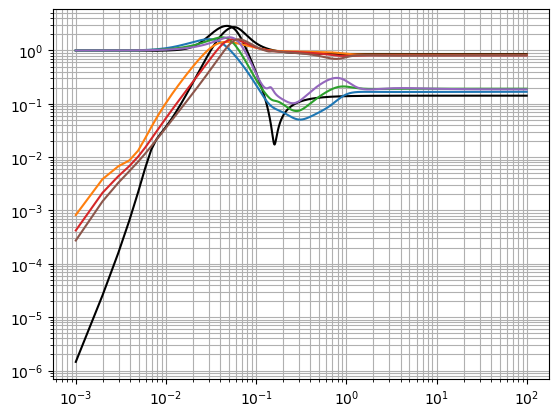

In [489]:
# plt.loglog(f, abs(h1(1j*2*np.pi*f)))
# plt.loglog(f, abs(2(1j*2*np.pi*f)))
plt.loglog(f, abs(cml_bb_sc(1j*2*np.pi*f)), "k")
plt.loglog(f, abs((1-cml_bb_sc)(1j*2*np.pi*f)), "k")

plt.loglog(f, abs(h1p(1j*2*np.pi*f)))
plt.loglog(f, abs(h2p(1j*2*np.pi*f)))

plt.loglog(f, abs(h1p_sigma1(1j*2*np.pi*f)))
plt.loglog(f, abs(h2p_sigma1(1j*2*np.pi*f)))

plt.loglog(f, abs(h1p_sigma2(1j*2*np.pi*f)))
plt.loglog(f, abs(h2p_sigma2(1j*2*np.pi*f)))

plt.grid(which="both")

In [457]:
h1_sigma2

TransferFunction(array([2.15555842e+07, 2.31206592e+09, 1.00933353e+11, 2.39126909e+12,
       3.53027012e+13, 3.57245808e+14, 2.60020470e+15, 1.36594385e+16,
       5.27078574e+16, 1.44719635e+17, 2.93463526e+17, 4.77148424e+17,
       5.96847834e+17, 6.37470044e+17, 5.22773044e+17, 3.70190698e+17,
       1.93004829e+17, 8.12703034e+16, 2.22279640e+16, 2.66616140e+15]), array([1.15395448e+08, 1.19467157e+10, 5.10073053e+11, 1.18834608e+13,
       1.71461867e+14, 1.68004496e+15, 1.19080742e+16, 6.19068782e+16,
       2.37704716e+17, 6.62163329e+17, 1.30657988e+18, 1.90032754e+18,
       2.22474674e+18, 2.03053590e+18, 1.48449740e+18, 8.56396471e+17,
       3.69943312e+17, 1.14419678e+17, 2.35135985e+16, 2.68932838e+15]))

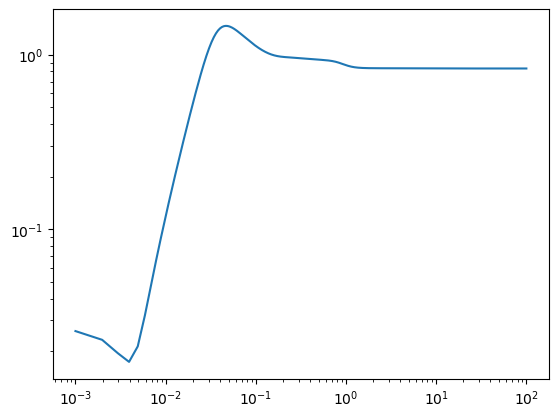

In [485]:
plt.loglog(f, abs(h2(1j*2*np.pi*f)))

In [486]:
#export

h2 = kontrol.TransferFunction(h2)
h2.save("sensor_correction_filters/h_sc_mean.pkl")

h2_sigma1 = kontrol.TransferFunction(h2_sigma1)
h2_sigma1.save("sensor_correction_filters/h_sc_sigma1.pkl")

h2_sigma2 = kontrol.TransferFunction(h2_sigma2)
h2_sigma2.save("sensor_correction_filters/h_sc_sigma2.pkl")

h_sc_prefilt = kontrol.TransferFunction(prefilt)
h_sc_prefilt.save("sensor_correction_filters/prefilt.pkl")

In [479]:
#export noise spectrums
np.savez("noise_spectrums/seismometer_mean.npz", f=f, data=res_mean)
np.savez("noise_spectrums/seismometer_sigma1.npz", f=f, data=res_sigma1)
np.savez("noise_spectrums/seismometer_sigma2.npz", f=f, data=res_sigma2)

np.savez("noise_spectrums/seismic_mean.npz", f=f, data=seis_mean)
np.savez("noise_spectrums/seismic_sigma1.npz", f=f, data=seis_sigma1)
np.savez("noise_spectrums/seismic_sigma2.npz", f=f, data=seis_sigma2)